<a href="https://colab.research.google.com/github/YamenHabib/ReinforcementLearning/blob/main/A2c_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


In [2]:
if COLAB:
  !sudo apt-get install -y xvfb ffmpeg x11-utils
  !pip install -q 'gym==0.17.0'
  !pip install -q 'imageio==2.4.0'
  !pip install -q PILLOW
  !pip install -q 'pyglet==1.4.0'
  !pip install -q pyvirtualdisplay
  !pip install -q tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


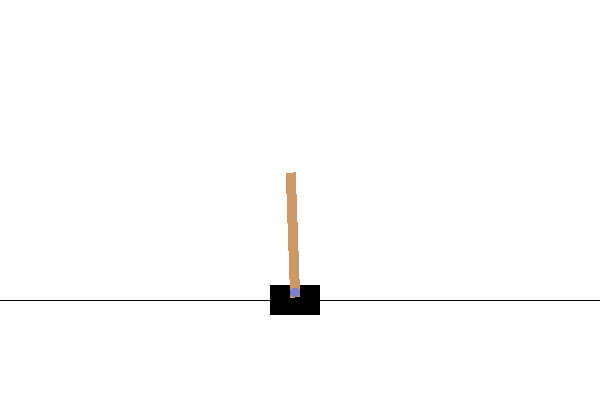

In [3]:
import tf_agents
from tf_agents.environments import suite_gym
import PIL.Image
import pyvirtualdisplay

display = pyvirtualdisplay.Display(visible=0, size=(1600, 1000)).start()

env_name = 'CartPole-v0'
env = suite_gym.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In [4]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [5]:
env.action_space

Discrete(2)

In [6]:
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers

%matplotlib inline

print("TensorFlow Ver: ", tf.__version__)

TensorFlow Ver:  2.4.1


In [7]:
if COLAB:
  env = wrap_env(gym.make(env_name))
else:
  env = gym.make(env_name)

env.reset()
done = False

i = 0
while not done:
    i += 1
    action = np.random.randint(2)
    state, reward, done, _ = env.step(action)
    env.render()
    print(f"Step {i}: Reward={reward}. done={done}")
    
env.close()

Step 1: Reward=1.0. done=False
Step 2: Reward=1.0. done=False
Step 3: Reward=1.0. done=False
Step 4: Reward=1.0. done=False
Step 5: Reward=1.0. done=False
Step 6: Reward=1.0. done=False
Step 7: Reward=1.0. done=False
Step 8: Reward=1.0. done=False
Step 9: Reward=1.0. done=False
Step 10: Reward=1.0. done=False
Step 11: Reward=1.0. done=False
Step 12: Reward=1.0. done=False
Step 13: Reward=1.0. done=False
Step 14: Reward=1.0. done=False
Step 15: Reward=1.0. done=False
Step 16: Reward=1.0. done=False
Step 17: Reward=1.0. done=False
Step 18: Reward=1.0. done=False
Step 19: Reward=1.0. done=False
Step 20: Reward=1.0. done=False
Step 21: Reward=1.0. done=False
Step 22: Reward=1.0. done=False
Step 23: Reward=1.0. done=False
Step 24: Reward=1.0. done=False
Step 25: Reward=1.0. done=False
Step 26: Reward=1.0. done=False
Step 27: Reward=1.0. done=False
Step 28: Reward=1.0. done=False
Step 29: Reward=1.0. done=False
Step 30: Reward=1.0. done=False
Step 31: Reward=1.0. done=True


In [8]:
show_video()

In [9]:
class Sampling(tf.keras.Model):
  def call(self, logits, **kwargs):
    return tf.squeeze(tf.random.categorical(logits, 1), axis=-1)

In [10]:
class Model(tf.keras.Model):
  def __init__(self, num_actions):
    super().__init__('mlp_policy')
    self.fc1 = layers.Dense(128, activation='relu')
    self.fc2 = layers.Dense(128, activation='relu')
    self.q_value = layers.Dense(1, name='value')

    self.policy_logits = layers.Dense(num_actions, name='policy_logits')
    self.sampling = Sampling()

  def call(self, inputs, **kwargs):
    x = tf.convert_to_tensor(inputs)
    hidden_logs = self.fc1(x)
    hidden_vals = self.fc2(x)
    return self.policy_logits(hidden_logs), self.q_value(hidden_vals)

  def action_value(self, obs):
    policy_logits, value = self.predict_on_batch(obs)
    action = self.sampling.predict_on_batch(policy_logits)
    return np.squeeze(action, axis=-1), np.squeeze(value, axis=-1)

In [11]:
# Verify everything works by sampling a single action.
env = gym.make('CartPole-v0')
model = Model(num_actions=env.action_space.n)
model.action_value(env.reset()[None, :])

(array(1), array([-0.00837735], dtype=float32))

In [16]:
class A2CAgent:
  def __init__(self, model, lr=7e-3, gamma=0.99, value_c=0.5, entropy_coefficient=1e-4):
    self.gamma = gamma
    self.value_c = value_c
    self.entropy_coefficient = entropy_coefficient
    self.model = model
    self.model.compile( optimizer=optimizers.RMSprop(lr=lr), loss=[self._action_logits_loss, self._value_loss])

  def train(self, env, batch_sz=64, updates=250):
    actions = np.empty((batch_sz,), dtype=np.int32)
    rewards, dones, values = np.empty((3, batch_sz))
    states = np.empty((batch_sz,) + env.observation_space.shape)
    
    ep_rewards = [0.0]
    next_state = env.reset()
    for update in range(updates):
      for step in range(batch_sz):
        states[step] = next_state.copy()
        actions[step], values[step] = self.model.action_value(next_state[None, :])
        next_state, rewards[step], dones[step], _ = env.step(actions[step])
        ep_rewards[-1] += rewards[step]
        if dones[step]:
          ep_rewards.append(0.0)
          next_state = env.reset()
          logging.info("Episode: %03d, Reward: %03d" % (len(ep_rewards) - 1, ep_rewards[-2]))

      _, q_value_tp1 = self.model.action_value(next_state[None, :])
      exp_rewards, advs = self._expected_rewards_advantages(rewards, dones, values, q_value_tp1)
      acts_and_advs = np.concatenate([actions[:, None], advs[:, None]], axis=-1)
      losses = self.model.train_on_batch(states, [acts_and_advs, exp_rewards])
      logging.debug("[%d/%d] Losses: %s" % (update + 1, updates, losses))

    return ep_rewards

  def test(self, env, render=False):
    states, done, ep_reward = env.reset(), False, 0
    while not done:
      action, _ = self.model.action_value(states[None, :])
      states, reward, done, _ = env.step(action)
      ep_reward += reward
      if render:
        env.render()
    return ep_reward

  def _expected_rewards_advantages(self, rewards, dones, values, q_value_tp1):
    expected_rewards = np.append(np.zeros_like(rewards), q_value_tp1, axis=-1)
    for t in reversed(range(rewards.shape[0])):
      expected_rewards[t] = rewards[t] + self.gamma * expected_rewards[t + 1] * (1 - dones[t])
    expected_rewards = expected_rewards[:-1]
    advantages = expected_rewards - values
    return expected_rewards, advantages

  def _value_loss(self, exp_rewards, value):
    return self.value_c * losses.mean_squared_error(exp_rewards, value)

  def _action_logits_loss(self, actions_and_advantages, logits):
    actions, advantages = tf.split(actions_and_advantages, 2, axis=-1)
    weighted_sparse_ce = losses.SparseCategoricalCrossentropy(from_logits=True)
    actions = tf.cast(actions, tf.int32)
    policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)

    probs = tf.nn.softmax(logits)
    entropy_loss = losses.categorical_crossentropy(probs, probs)

    return policy_loss - self.entropy_coefficient * entropy_loss


In [17]:
# Verify everything works with random weights.
agent = A2CAgent(model)
rewards_sum = agent.test(env)
print("Total Episode Reward: %d out of 200" % agent.test(env))

Total Episode Reward: 25 out of 200


# Training

In [18]:
logging.getLogger().setLevel(logging.INFO)
model = Model(num_actions=env.action_space.n)
agent = A2CAgent(model)
rewards_history = agent.train(env, batch_sz=64, updates=300)

INFO:root:Episode: 001, Reward: 017
INFO:root:Episode: 002, Reward: 026
INFO:root:Episode: 003, Reward: 035
INFO:root:Episode: 004, Reward: 013
INFO:root:Episode: 005, Reward: 014
INFO:root:Episode: 006, Reward: 014
INFO:root:Episode: 007, Reward: 015
INFO:root:Episode: 008, Reward: 019
INFO:root:Episode: 009, Reward: 036
INFO:root:Episode: 010, Reward: 014
INFO:root:Episode: 011, Reward: 030
INFO:root:Episode: 012, Reward: 023
INFO:root:Episode: 013, Reward: 066
INFO:root:Episode: 014, Reward: 059
INFO:root:Episode: 015, Reward: 036
INFO:root:Episode: 016, Reward: 017
INFO:root:Episode: 017, Reward: 200
INFO:root:Episode: 018, Reward: 061
INFO:root:Episode: 019, Reward: 019
INFO:root:Episode: 020, Reward: 102
INFO:root:Episode: 021, Reward: 035
INFO:root:Episode: 022, Reward: 037
INFO:root:Episode: 023, Reward: 092
INFO:root:Episode: 024, Reward: 035
INFO:root:Episode: 025, Reward: 138
INFO:root:Episode: 026, Reward: 074
INFO:root:Episode: 027, Reward: 049
INFO:root:Episode: 028, Rewa

In [24]:
if COLAB:
  env = wrap_env(gym.make(env_name))
else:
  env = gym.make(env_name)


env.reset()
done = False

obs, done, ep_reward = env.reset(), False, 0
while not done:
  action, _ = agent.model.action_value(obs[None, :])
  obs, reward, done, _ = env.step(action)
  ep_reward += reward
  env.render()
env.close()
ep_reward

200.0

In [25]:
show_video()